# Prediction models for Project1

This notebook explores the following models:

  * MeanModel - Predicts mean value for all future values
  * LastDayModel - Predicts the same values like last day (given as futures)
  
Table of contents:

  * Load model and create training and test datasets
  * Evaluate Mean model
  * Evaluate LastDayModel
  * Explore error

In [2]:
import datetime
import calendar
import pprint
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4

# Load project

In [3]:
project_folder = '../../datasets/project1/'
with open(project_folder + 'project.json', 'r') as file:
    project = json.load(file)
pprint.pprint(project)
print('Flow1')
flow = pd.read_csv(project_folder + 'flow1.csv', parse_dates=['time'])
flow = flow[(flow.time >= project['start-date']) & (flow.time < project['end-date'])]
print(flow.info())
flow.head()

{'end-date': '2017-11-09',
 'flows': ['flow1'],
 'name': 'Project1',
 'rainfalls': [],
 'split-date': '2016-11-10',
 'start-date': '2013-09-10'}
Flow1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 437823 entries, 158 to 437980
Data columns (total 2 columns):
time    437823 non-null datetime64[ns]
flow    437823 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.0 MB
None


,time,flow
158,2013-09-10 00:00:00,0.0
159,2013-09-10 00:05:00,0.0
160,2013-09-10 00:10:00,0.0
161,2013-09-10 00:15:00,0.0
162,2013-09-10 00:20:00,0.0


## Create train and test dataset

Dataset consists of the following features:

  * Vector of last 24h data
  
and target value:

  * Vector of next 24 predictions

In [4]:
flow['day'] = flow.time.map(pd.Timestamp.date)
flow['hour'] = flow.time.map(pd.Timestamp.time)
target = flow.pivot(index='day', columns='hour', values='flow')
target = target.fillna(0)
features = target.shift()
# Skip first days as they are 0.0 anyway
target = target[datetime.date(2013, 9, 13):]
features = features[datetime.date(2013, 9, 13):]
# Now lets create train and test dataset on given split day
split_day = datetime.date(2016, 11, 11)
X_train = features[:split_day].values
Y_train = target[:split_day].values
X_test = features[split_day:].values
Y_test = target[split_day:].values
X_test.shape

(363, 288)

## Helper functions

Helper functions for building training and test sets and calculating score

In [5]:
class PredictionModel:
    
    def fit(self, X, Y):
        pass
        
    def predict(self, X):
        pass

    
def mae(y_hat, y):
    """
    Calculate Mean Absolute Error
    """
    return np.sum(np.absolute(y_hat-y), axis=1)/y.shape[0]

    
def evaluate_model(model):
    """
    Evaluate model on all days starting from split_day.
    Returns 90th percentile error as model score
    """
    model.fit(X_train, Y_train)
    costs = mae(model.predict(X_test), Y_test)
    return np.percentile(costs, 90), costs

# Models

## ConstantMeanModel

Calculate mean from all datapoint in the training set. 
Ignore features and predict constant value (equal to this mean) for all predicted values

In [6]:
class ConstantMeanModel(PredictionModel):
    
    def __init__(self):
        self.mu = 0
    
    def fit(self, X, y):
        self.mu = np.mean(y)
        
    def predict(self, X):
        return np.ones(X.shape) * self.mu    

score, costs = evaluate_model(ConstantMeanModel())
print('ConstantMeanModel score: {:.2f}'.format(score))

ConstantMeanModel score: 15.01


## Last day model

Here our model will predict the same values like they were in the previos day

In [7]:
class LastDayModel(PredictionModel):
    
    def fit(self, X, y):
        pass
        
    def predict(self, X):
        return X.copy()


score, costs = evaluate_model(LastDayModel())
print('LastDayModel score: {:.2f}'.format(score))

LastDayModel score: 7.57


### Explore errors

Check the biggest errors for Last day model:

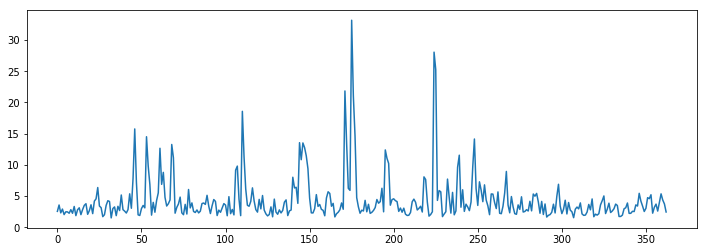

In [8]:
plt.plot(costs)
plt.show()

In [43]:
df = pd.DataFrame({'day': target[split_day:].index, 'cost': costs})
df['weekday'] = df['day'].apply(lambda x: calendar.day_name[x.weekday()])
df_sorted = df.sort_values(by=['cost'], ascending=False)
df_sorted.head(10)

,cost,day,weekday
175,33.159913,2017-05-05,Friday
224,28.047846,2017-06-23,Friday
225,25.246026,2017-06-24,Saturday
171,21.828717,2017-05-01,Monday
176,21.054808,2017-05-06,Saturday
110,18.565481,2017-03-01,Wednesday
46,15.744336,2016-12-27,Tuesday
177,14.640153,2017-05-07,Sunday
53,14.494078,2017-01-03,Tuesday
248,14.131128,2017-07-17,Monday


#### Explore daily flow

The biggest error is at 2017-06-23 (Friday) (and in the next day)

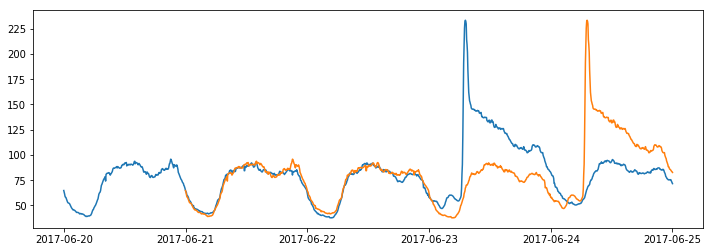

In [47]:
def plot_days(start_day, end_day, show_prediction=True):
    df = flow[(flow.time >= start_day) & (flow.time <= end_day)].set_index('time').flow
    plt.plot(df)
#     df.plot()
    if show_prediction:
        plt.plot(df.shift(288))
    plt.show()
    
plot_days('2017-06-20', '2017-06-25')

This can probably be atributed to anamaly in data reading. 

Or some problems in the network (kind of congestions)

Lets check week 2017-05-01 (Monday)

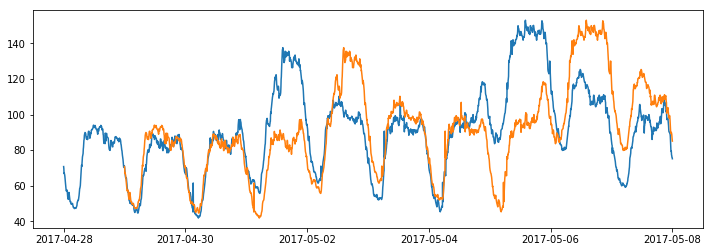

In [48]:
plot_days('2017-04-28', '2017-05-8')    

Given flow in those days, it is not suprising that the model is not working here